# Image classification using CNNs and pytorch

pytorch와 합성곱 신경망을 이용해 사과 이미지 분류하기.

출처: [플로우가 보이는 머신러닝 프로젝트 Ch5 (TensorFlow + Keras)](https://github.com/jasonyim2/book1/tree/main/Ch5)를 Pytorch로 변환했습니다. 

## 1.Identify the problem.

Your goal is indeed to classify pictures of apples into specific categories:

- Apple Braebum
- Apple Crimson Snow
- Apple Golden 1
- Apple Golden 2
- Apple Golden 3

Since there are three distinct categories, this is a **multiclass image classification** problem.

## 2.Choose the model and framework.

- You decided to use a **pre-trained** image classification model and fine-tune it, which is a suitable approach, especially when you might have a **limited amount of labeled data**.
- A **pre-trained model** is a model that has already been trained on a large dataset for a related task (like general image classification), and you leverage its existing knowledge.
- You chose **EfficientNet-B0** as the specific pre-trained model. PyTorch provides access to many pre-trained models, including GoogleNet, within its `torchvision.models` library.
- You decided to use **PyTorch** as your deep learning framework. PyTorch is a powerful framework, but it requires you to manually specify the device (like a GPU) to use, unlike some other frameworks that auto-detect it. You would typically set a device variable (e.g., 'cuda' if a GPU is available, otherwise 'cpu') and move your model, data, and labels to this device. Using a GPU (like a T4) is highly recommended for deep learning tasks to significantly speed up the training process

## 3. Collect and prepare the data set.

- You collected the data set containing pictures of apples and their corresponding labels for the five categories.
- The specific "Apple classification" [data set is available on **Kaggle**](https://www.kaggle.com/datasets/barisyasli/fruit360). It is often provided in a structured format, perhaps with image file paths and corresponding category labels.
- Since Fruits 360 data set is too large, I will only use "Apple" data set.
- Before using the data in PyTorch, it needs some preparation:
  - If labels are strings (like 'Apple Braebum', 'Apple Crimson Snow', ...), you would typically encode them into integers (e.g., 0, 1, ...) using a tool like `LabelEncoder` from `Scikit-learn`.
  - Images need to be **preprocessed** consistently. Common steps include **resizing** all images to a uniform size (e.g., 128x128 pixels), converting them from image format (like `PIL` Image) into **PyTorch tensors**, and ensuring they have the correct data type (e.g., `torch.float`). PyTorch's `torchvision.transforms.Compose` can chain these preprocessing steps together.
  - You will likely need to create a **custom PyTorch Dataset class** to define how to load your specific data (image paths and labels) and apply the necessary preprocessing transforms. This class inherits from `torch.utils.data.Dataset` and requires methods like `__len__` (to return the dataset size) and `__getitem__` (to load and preprocess a single data sample by index).
  - The prepared dataset samples (images and labels) should be converted to **PyTorch tensors** and moved to your chosen device (GPU/CPU).

**Using google colab**

```
drive/MyDrive/Data/fruits-360-5/
├── Training/
│   ├── Apple Braeburn/ (492 files)
│   │   ├── 0_100.jpg
│   │   ├── 100_100.jpg
│   │   └── ...
│   ├── Apple Crimson Snow/ (444 files)
│   │   ├── 0_100.jpg
│   │   ├── 10_100.jpg
│   │   └── ...
│   ├── Apple Golden 1/ (492 files)
│   │   ├── 0_100.jpg
│   │   ├── 100_100.jpg
│   │   └── ...
│   └── Apple Golden 2/ (492 files)
│   │   ├── 0_100.jpg
│   │   ├── 100_100.jpg
│   │   └── ...
│   └── Apple Golden 3/ (481 files)
│       ├── 0_100.jpg
│       ├── 100_100.jpg
│       └── ...
|
└── Test/
    ├── Apple Braeburn/ (164 files)
    │   ├── 0_100.jpg
    │   ├── 10_100.jpg
    │   └── ...
    ├── Apple Crimson Snow/ (148 files)
    │   ├── 0_100.jpg
    │   ├── 10_100.jpg
    │   └── ...
    └── Apple Golden 1/ (164 files)
    │   ├── 0_100.jpg
    │   ├── 10_100.jpg
    │   └── ...
    └── Apple Golden 2/ (164 files)
    │   ├── 0_100.jpg
    │   ├── 10_100.jpg
    |   └── ...
    └── Apple Golden 3/ (161 files)
        ├── 0_100.jpg
        ├── 10_100.jpg
        └── ...
```

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 구글 드라이브에 미리 올린 압축파일을 풀기 위해 라이브러리를 불러오기
import zipfile

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Data/fruits-360-5.zip', 'r') # 압축 파일(zip file) 읽기
zip_ref.extractall('/content/drive/MyDrive/Data/') # 압출 파일을 풀어서 지정한 폴더(예: Data 폴더)에 저장
zip_ref.close()

## 4. Divide the data set

- You divided your data set into a **training set** and a **validation set**.
- The **training set** is used to train the model, adjusting its weights and biases.
- The **validation set** is used to evaluate the model's performance during training, typically after each epoch, to monitor its progress on data it hasn't directly seen during training and to help detect issues like overfitting.
- The source for the Fruits 360 dataset it is only provided with a train set. While the Fruits 360 source example primarily focuses on train/test, including a validation set is a good practice for final evaluation.
- A standard split often includes a third set: a **test set** (e.g., 70% train, 15% validation, 15% test). A test set is used only once after training is completely finished to provide an unbiased estimate of the model's performance on truly unseen data.
- PyTorch's `DataLoader` is used to create iterators that provide data in batches from your dataset. You would create separate DataLoaders for your training and validation sets. The DataLoader manages batching and can shuffle the data (especially important for the training set)

In [2]:
# Importing
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

In [3]:
# detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
image_path = []  # Stores paths to all images
labels = []     # Stores corresponding labels
data_dir = '/content/drive/MyDrive/Data/fruits-360-5'

for i in os.listdir(data_dir): # Looping through the first directory which has the train and val images
  # i = Training or Test
  for label in os.listdir(f"{data_dir}/{i}"): # Looping through the first directory which has the labels folders
    # label = Apple Braeburn or Apple Crimson Snow or Apple Golden 1, 2, 3
    for image in os.listdir(f"{data_dir}/{i}/{label}"): # Looping through all the images of this label
      labels.append(label) # Append/Put this label in the list
      image_path.append(f"{data_dir}/{i}/{label}/{image}") # Append/Put this image path in the list to read it later

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels']) # Create a dataframe contains the images paths and the labels

print("Data shape is: ", data_df.shape)
print()
data_df.head() # Visualizing the first 5 rows by default

Data shape is:  (3186, 2)



,image_paths,labels
0,/content/drive/MyDrive/Data/fruits-360-5/Test/...,Apple Golden 2
1,/content/drive/MyDrive/Data/fruits-360-5/Test/...,Apple Golden 2
2,/content/drive/MyDrive/Data/fruits-360-5/Test/...,Apple Golden 2
3,/content/drive/MyDrive/Data/fruits-360-5/Test/...,Apple Golden 2
4,/content/drive/MyDrive/Data/fruits-360-5/Test/...,Apple Golden 2


**Split the data**

- Clean train/val/test split with stratification (70/15/15)

In [5]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
train_df, temp_df = train_test_split(data_df, test_size=0.3, stratify=data_df['labels'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels'], random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 2230
Validation samples: 478
Testing samples: 478


## 5. Dataset & Transforms

In [6]:
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from PIL import Image # Used to read the images from the directory

label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels']) # Fit the label encoder once on all categories

class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe['labels']))

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    return image, label

In [7]:
import torchvision
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images

# Enhanced data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet stats
])

# Keep validation transforms simpler
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### DataLoader and batch

Okay, let's delve into more details about **PyTorch's `DataLoader`** and **batches**, building upon your process description and the information from the sources.

100개의 데이터를 batch_size=5로 설정하면 → 100 ÷ 5 = 20개의 배치가 생기고 `DataLoader`는 이 계산대로 실제로 5개씩 데이터를 묶어서 차례차례 꺼내 주는 구현체/class 이다.

1.  **What is a `DataLoader`?**
    *   A `DataLoader` is a PyTorch object that wraps a PyTorch `Dataset`.
    *   Its primary function is to provide an efficient way to **iterate through a dataset in batches**.
    *   Think of it as a mechanism that helps you *load* your data during the training process.

2.  **Why use Batches?**
    *   When training deep learning models, you don't typically feed individual data points one by one. Instead, you process them in **groups or batches**.
    *   Processing data in batches is much more computationally efficient, especially when using hardware accelerators like **GPUs**. A GPU can perform parallel computations on multiple data points simultaneously.
    *   The gradient calculations and weight updates during training are performed based on the average error across a batch, which provides a more stable learning signal compared to updating weights based on each single data point.

3.  **How `DataLoader` works with Batches:**
    *   The `DataLoader` takes your `Dataset` and divides it into smaller, manageable chunks based on a specified **`batch_size`**.
    *   During each **epoch** (a full pass through the entire dataset), you use a `for` loop to iterate over the `DataLoader`.
    *   In each iteration of this loop, the `DataLoader` yields one **batch** of data. This batch contains a group of input samples (images in your case) and their corresponding labels, according to the defined `batch_size`.
    *   The source illustrates this by showing how iterating through a `DataLoader` provides `inputs, labels` where the inputs and labels have a dimension corresponding to the batch size. For example, if the `batch_size` is 8, a loop iteration would yield inputs with a shape reflecting 8 samples and labels with a shape reflecting 8 labels.

4.  **Key Parameters of `DataLoader`:**
    *   **`dataset`**: This is the PyTorch `Dataset` object that the `DataLoader` will load data from. In your process, you would create separate `CustomImageDataset` instances for your training and validation dataframes, and then pass these dataset instances to the respective `DataLoader` constructors.
    *   **`batch_size`**: This integer determines the number of data samples included in each batch. The sources show examples using different batch sizes, such as 8, 16, or 32. You define this as a hyperparameter.
    *   **`shuffle`**: This is a boolean parameter, commonly set to `True` for the training `DataLoader`. When `shuffle=True`, the order of the data samples is randomized before each epoch. This helps to prevent the model from learning the order of the data or being biased towards certain patterns that might appear sequentially in the dataset. For validation and testing data loaders, `shuffle` is typically set to `False`.

In essence, `DataLoader` is the utility that makes the batch-wise processing of your dataset seamless and efficient in PyTorch, managing the data loading, batching, and optional shuffling for you.

In [8]:
# Set Hypervariable
BATCH_SIZE = 4
EPOCHS = 15

In [9]:
train_dataset = CustomImageDataset(dataframe=train_df, transform=train_transform)
val_dataset = CustomImageDataset(dataframe=val_df, transform=val_transform)
test_dataset = CustomImageDataset(dataframe=test_df, transform=val_transform)

# Not specifying num_workers=0 can lead to multiprocessing issues in notebook environments like Colab.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## 6. Model Selection and Fine-tuning

We use a recent model architecture with better performance.

- EfficientNet-B0 with proper transfer learning setup
- Strategic layer freezing to prevent overfitting
- Dropout in the classifier for regularization
- Adding a learning rate scheduler can help converge faster and achieve better results

In [10]:
from torchvision import models # import pretrained models in PyTorch library
from torchvision.models import EfficientNet_B0_Weights # Use a more modern architecture like EfficientNet or ResNet

# 1. Choose the pretrained weights
weights = EfficientNet_B0_Weights.DEFAULT  # or .IMAGENET1K_V1 if you need the older ones

# 2. Load the model with those weights
model = models.efficientnet_b0(weights=weights)

# 3. Freeze everything except the classifier head
for name, param in model.named_parameters():
    # any parameter *not* in the classifier will be frozen
    if not name.startswith("classifier"):
        param.requires_grad = False

# 4. Replace the classifier to match your num_classes
num_classes = data_df["labels"].nunique()
in_features = model.classifier[1].in_features  # the penultimate layer’s size

model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, num_classes)
)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 171MB/s]


In [12]:
import torch.optim as optim

# Optimizer with weight decay for regularization
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# lr = Learning rate
# weight_decay = L2 regularization

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

# Cross Entropy Loss function
criterion = nn.CrossEntropyLoss()

## 7. Training Pipeline:

- Mixed precision training with autocast and GradScaler
- Early stopping with best model saving
- ReduceLROnPlateau scheduler properly configured
- Clean training/validation loops with metric tracking

### 혼합 정밀도(mixed precision)

- `with autocast():` 혼합 정밀도(mixed precision)를 사용하는 코드:

`autocast()`는 PyTorch에서 자동으로 float16(반정밀도) 과 float32(정밀도) 를 적절히 섞어서 계산하게 해주는 핵심 함수이다. `with autocast():` 블록 안에서 계산되는 연산들은 자동으로 더 빠르고 메모리를 덜 쓰는 float16으로 처리된다. 다만, float16만 쓰면 문제가 생기니까 PyTorch가 자동으로 필요한 부분만 float32로 처리한다.

이렇게 정밀도를 섞어서 처리하는 걸 **혼합 정밀도(mixed precision)** 라고 한다. mixed precision이 있으면 GradScaler도 함께 써야 훈련이 안정적으로 된다.

### mixed precision with GradScaler

GradScaler는 정확도에 영향이 없고, 훈련을 안정적으로 만드는 도구.

- float32(기본 정밀도) 로만 훈련하면 → GradScaler 없어도 됨!
- float16(혼합 정밀도) 를 쓰고 있으면 → GradScaler를 없애면 훈련이 불안정해질 수 있어(NaN 나올 수 있음).

| 기능      | 혼합 정밀도 사용            | 혼합 정밀도 미사용 (지금 코드) |
| ------- | -------------------- | ------------------ |
| 연산 속도   | 빠름 (특히 A100 등 GPU에서) | 조금 느릴 수 있음         |
| 메모리 사용량 | 적음                   | 조금 더 많음            |
| 코드 복잡도  | autocast + scaler 필요 | 훨씬 단순함             |
| 안정성     | scaler가 필요함          | 기본 float32라 안정적임   |

### 실전 code

GPU가 지원하고, 안정성 문제만 없다면 가능하면 **mixed precision(혼합 정밀도)**를 사용한다.

최근 논문 코드나 Kaggle top-solution 대부분이 mixed precision을 사용한다. 특히 대규모 모델이나 Vision/Transformer 쪽은 거의 기본 세팅이다.

- 예: OpenAI, Meta, Google 논문 코드 보면 다 autocast() 켜져 있음.

❗ **장점**
- 속도 빠름: 학습 시간 최대 2배 가까이 단축될 수 있어. (시간 = 돈)
- GPU 메모리 절약: 더 큰 배치도 가능하거나, 더 복잡한 모델 사용 가능.
  - 메모리 효율이 좋아서 더 많은 실험을 한꺼번에 돌릴 수 있음.
- PyTorch에서 `autocast()` + `GradScaler()` 덕분에 안정성도 대부분 확보됨.

❗ **그럼 언제 float32 쓰는 게 더 나을까?**
- 디버깅 중일 때: float32가 더 직관적이고 안정적이라 문제 추적하기 쉬워.
- 특정 모델이 float16에서 NaN을 자주 뿜을 때
- 낮은 성능의 GPU 사용 중일 때 (예: float16 지원이 약한 GTX 시리즈 등)

In [13]:
# Create a complete training function that integrates early stopping and mixed precision
# Add this after defining the model, optimizer, and criterion

from torch.amp import autocast, GradScaler

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15, patience=5):
    # Initialize the scaler for mixed precision
    scaler = GradScaler()

    best_val_loss = float('inf')
    counter = 0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Mixed precision training
            with autocast(device_type=device):
                outputs = model(inputs) # 1. Do the forward pass
                loss = criterion(outputs, labels) # 2. Calculate the loss

            # Scale the loss and do backward pass
            optimizer.zero_grad() # 3. reset gradients
            scaler.scale(loss).backward() # 4. Perfom backpropagation
            scaler.step(optimizer) # 5. Update the model
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs) # 1. Do the forward pass
                loss = criterion(outputs, labels) # 2. Calculate the loss

                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = 100. * correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        # Update learning rate
        scheduler.step(epoch_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_losses, train_accs, val_losses, val_accs

## 8. Evaluation & Visualization:

- Separate evaluation function for test set
- Clear visualization of training metrics

In [14]:
# Add a proper evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100. * correct / total
    print(f'Test Accuracy: {test_acc:.2f}%')
    return test_acc

In [15]:
# Add a cell to run the training (it takes 30m in google colab)
model, train_losses, train_accs, val_losses, val_accs = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=EPOCHS,
    patience=5
)

Epoch 1/15:
Train Loss: 0.8849, Train Acc: 67.49%
Val Loss: 0.4163, Val Acc: 81.80%
Saved best model with validation loss: 0.4163
Epoch 2/15:
Train Loss: 0.6671, Train Acc: 74.22%
Val Loss: 0.3464, Val Acc: 84.31%
Saved best model with validation loss: 0.3464
Epoch 3/15:
Train Loss: 0.5922, Train Acc: 77.44%
Val Loss: 0.4086, Val Acc: 81.38%
Epoch 4/15:
Train Loss: 0.6052, Train Acc: 76.86%
Val Loss: 0.2374, Val Acc: 91.63%
Saved best model with validation loss: 0.2374
Epoch 5/15:
Train Loss: 0.5718, Train Acc: 78.65%
Val Loss: 0.3011, Val Acc: 85.15%
Epoch 6/15:
Train Loss: 0.5706, Train Acc: 78.57%
Val Loss: 0.2314, Val Acc: 88.91%
Saved best model with validation loss: 0.2314
Epoch 7/15:
Train Loss: 0.5407, Train Acc: 79.24%
Val Loss: 0.2633, Val Acc: 92.05%
Epoch 8/15:
Train Loss: 0.5454, Train Acc: 79.24%
Val Loss: 0.2289, Val Acc: 91.84%
Saved best model with validation loss: 0.2289
Epoch 9/15:
Train Loss: 0.5110, Train Acc: 81.48%
Val Loss: 0.2482, Val Acc: 89.96%
Epoch 10/15:
T

In [16]:
# Add this to a new cell BEFORE your training cell
try:
    print("Attempting to get the first item from train_dataset...")
    first_image, first_label = train_dataset[0]
    print(f"Successfully retrieved first item.")
    print(f"Image type: {type(first_image)}, Label type: {type(first_label)}")
    # If image is a tensor, print shape:
    if isinstance(first_image, torch.Tensor):
        print(f"Image shape: {first_image.shape}")
except Exception as e:
    print(f"Error getting first item from train_dataset: {e}")
    import traceback
    traceback.print_exc() # Print detailed traceback if there's an error

Attempting to get the first item from train_dataset...
Successfully retrieved first item.
Image type: <class 'torch.Tensor'>, Label type: <class 'torch.Tensor'>
Image shape: torch.Size([3, 224, 224])


In [17]:
# Add a cell to evaluate on test set
test_acc = evaluate_model(model, test_loader)

Test Accuracy: 92.89%


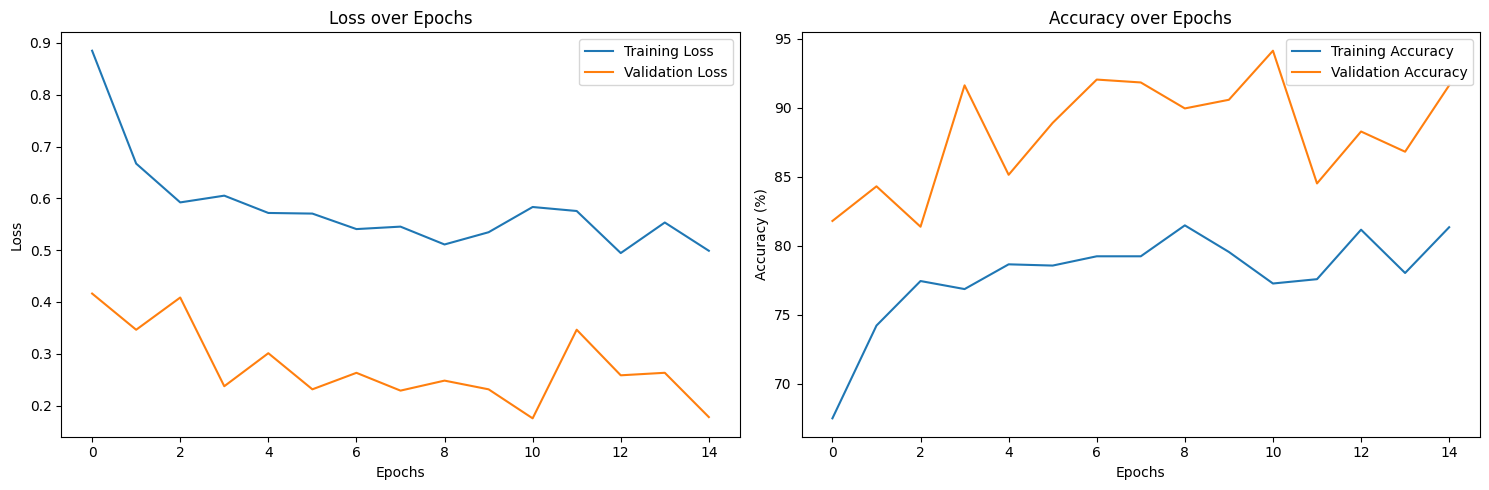

In [18]:
# Add a cell to visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()